In [1]:
#Imports for CCD
from osgeo import gdal
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date
import numpy as np
%matplotlib inline
import ccd



In [2]:
# Input Pixels
#pixel coordinates
pixel_x =11
pixel_y =29
data='fusion'
sample_size=30
nth=1
parent_dir='/Users/arthur.platel/Desktop/Fusion_Images/CZU_FireV2'


In [3]:
from ccd import data_input

#import data from images
data = data_input.get_data(parent_dir,pixel_x,pixel_y,sample_size,nth,d=data)
dates, blues, greens, reds, nirs, ndvis, ndwis, qas = data

params = {'QA_BITPACKED': False,
              'QA_FILL': 255,
              'QA_CLEAR': 0,
              'QA_WATER': 1,
              'QA_SHADOW': 2,
              'QA_SNOW': 3,
              'QA_CLOUD': 4}


images used: 1278


In [4]:
#calculate results using ccd
results = ccd.detect(dates, blues, greens, reds, nirs, ndvis, ndwis, qas, params)



In [5]:
#print CCD output
for seq in results["change_models"]:
    print(seq)
  



{'start_day': 736695, 'end_day': 737653, 'break_day': 737654, 'observation_count': 959, 'change_probability': 1.0, 'curve_qa': 8, 'blue': {'rmse': 17.823939840189524, 'coefficients': (-0.02113782593840735, -64.7971275989173, 6.993119131039076, 1.2613096404120865, -0.6175231542870432, 2.742804744536837, 4.090997601997344), 'intercept': 15712.788203517759, 'magnitude': 51.9048520045817}, 'green': {'rmse': 16.289882036636445, 'coefficients': (0.008943883785134476, -140.88205850973966, 3.6874452055500138, 14.567601110376058, -2.155733543444848, -2.2525390514649137, 7.302150365078726), 'intercept': -6374.637880002918, 'magnitude': 33.477181427643245}, 'red': {'rmse': 14.66120039269478, 'coefficients': (-0.0020460584553975663, -78.45570595575809, 5.986373945552493, 7.001535733435509, -0.10026510198087503, 0.03935569371200169, 3.325867722561607), 'intercept': 1637.7342705835379, 'magnitude': 186.74720796464078}, 'nir': {'rmse': 90.89371935523376, 'coefficients': (0.4523004890946685, -939.8076

11 29


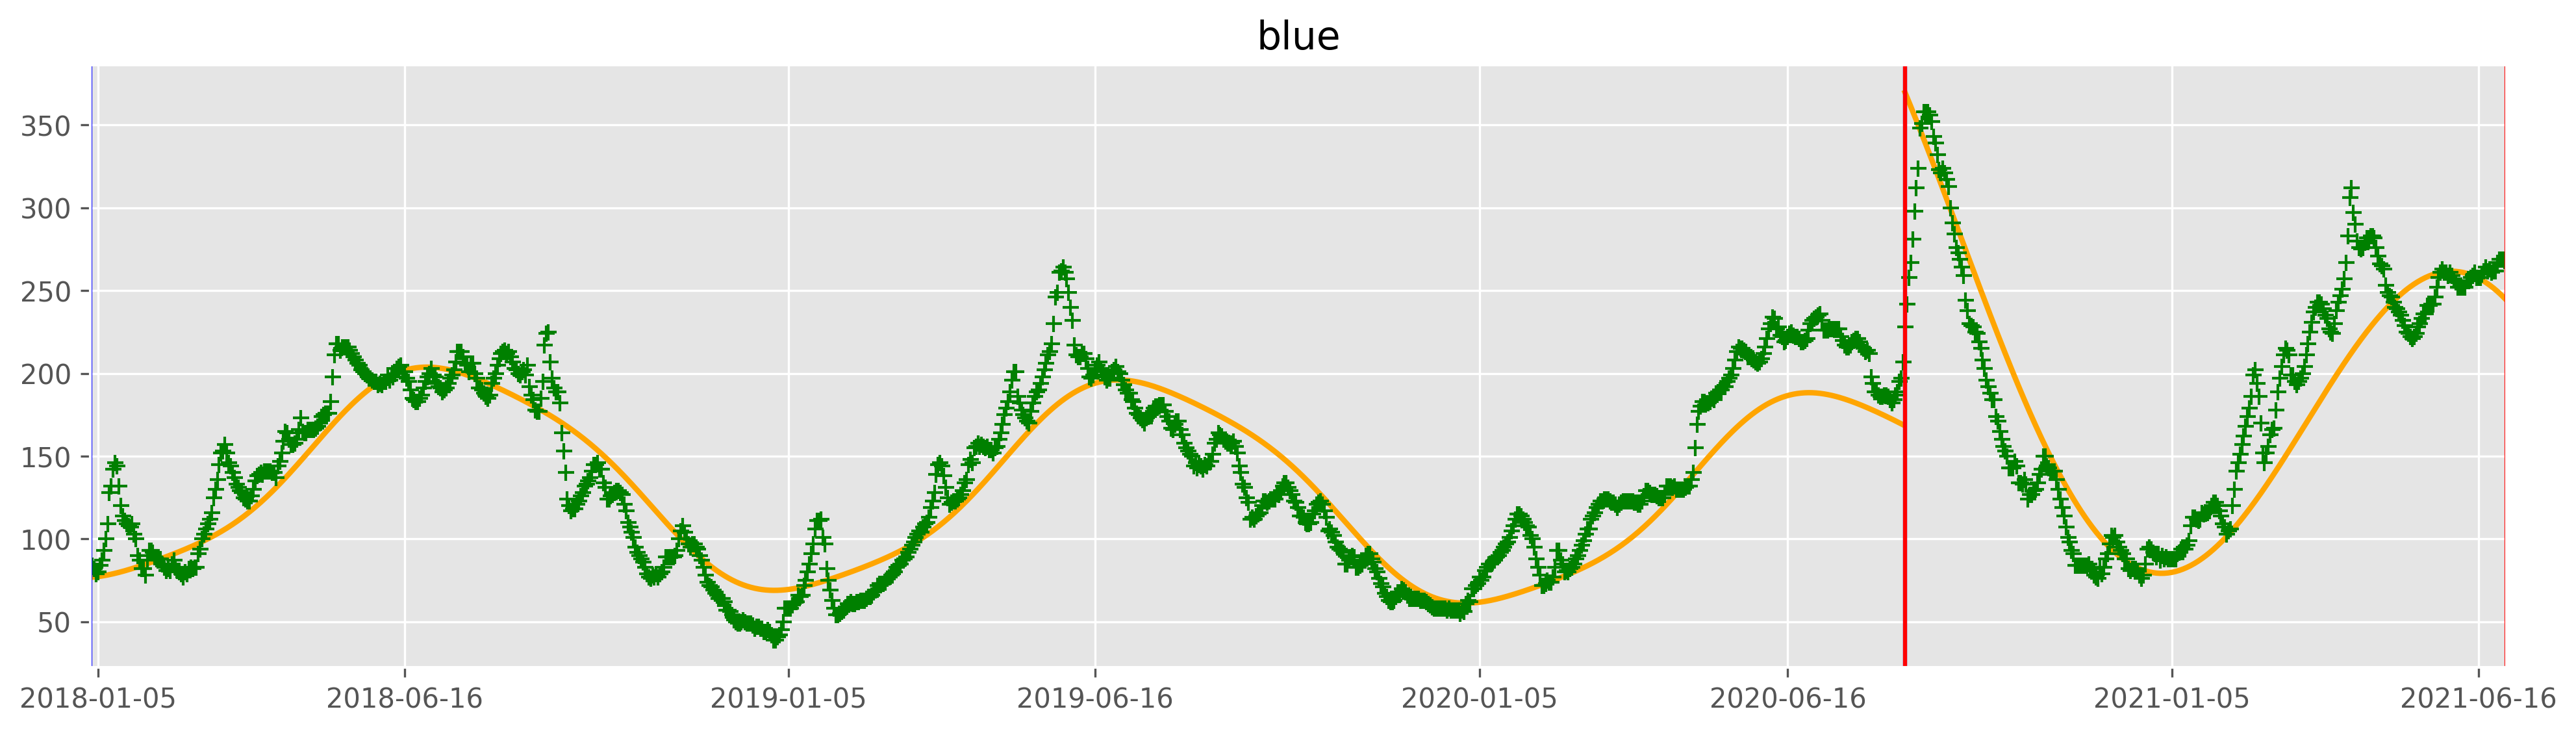

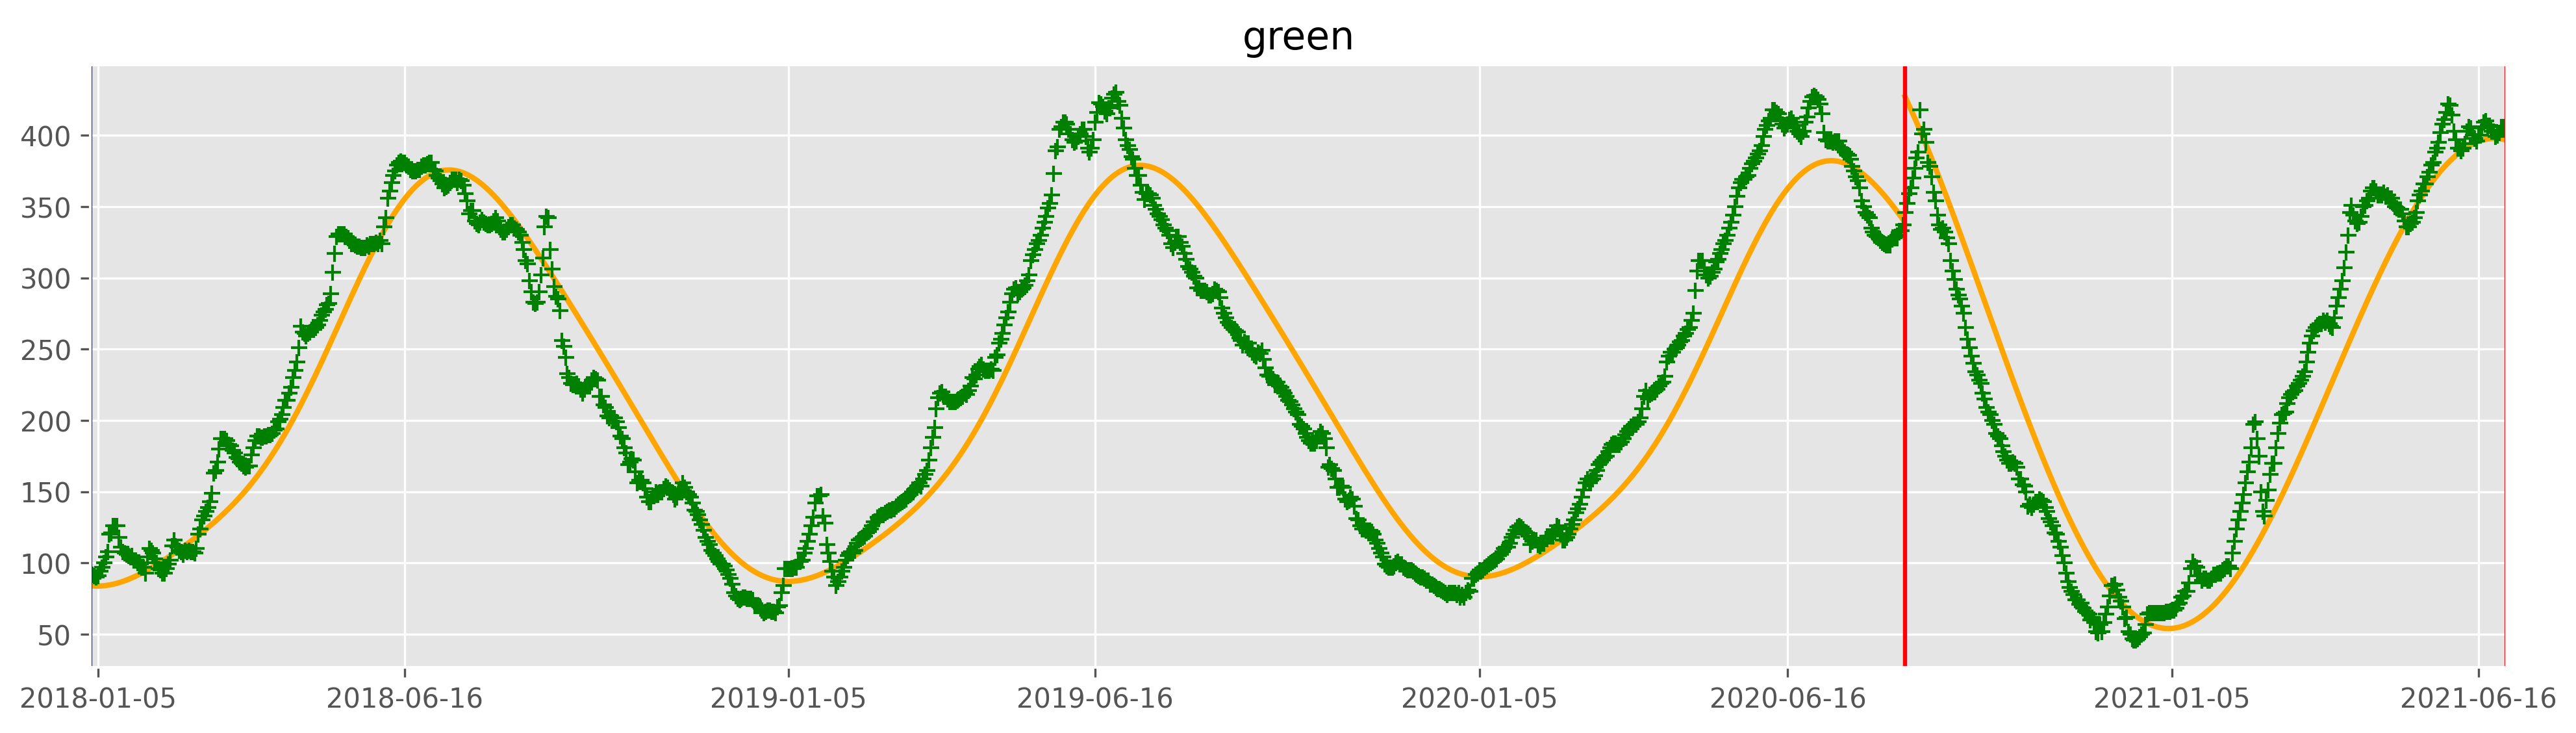

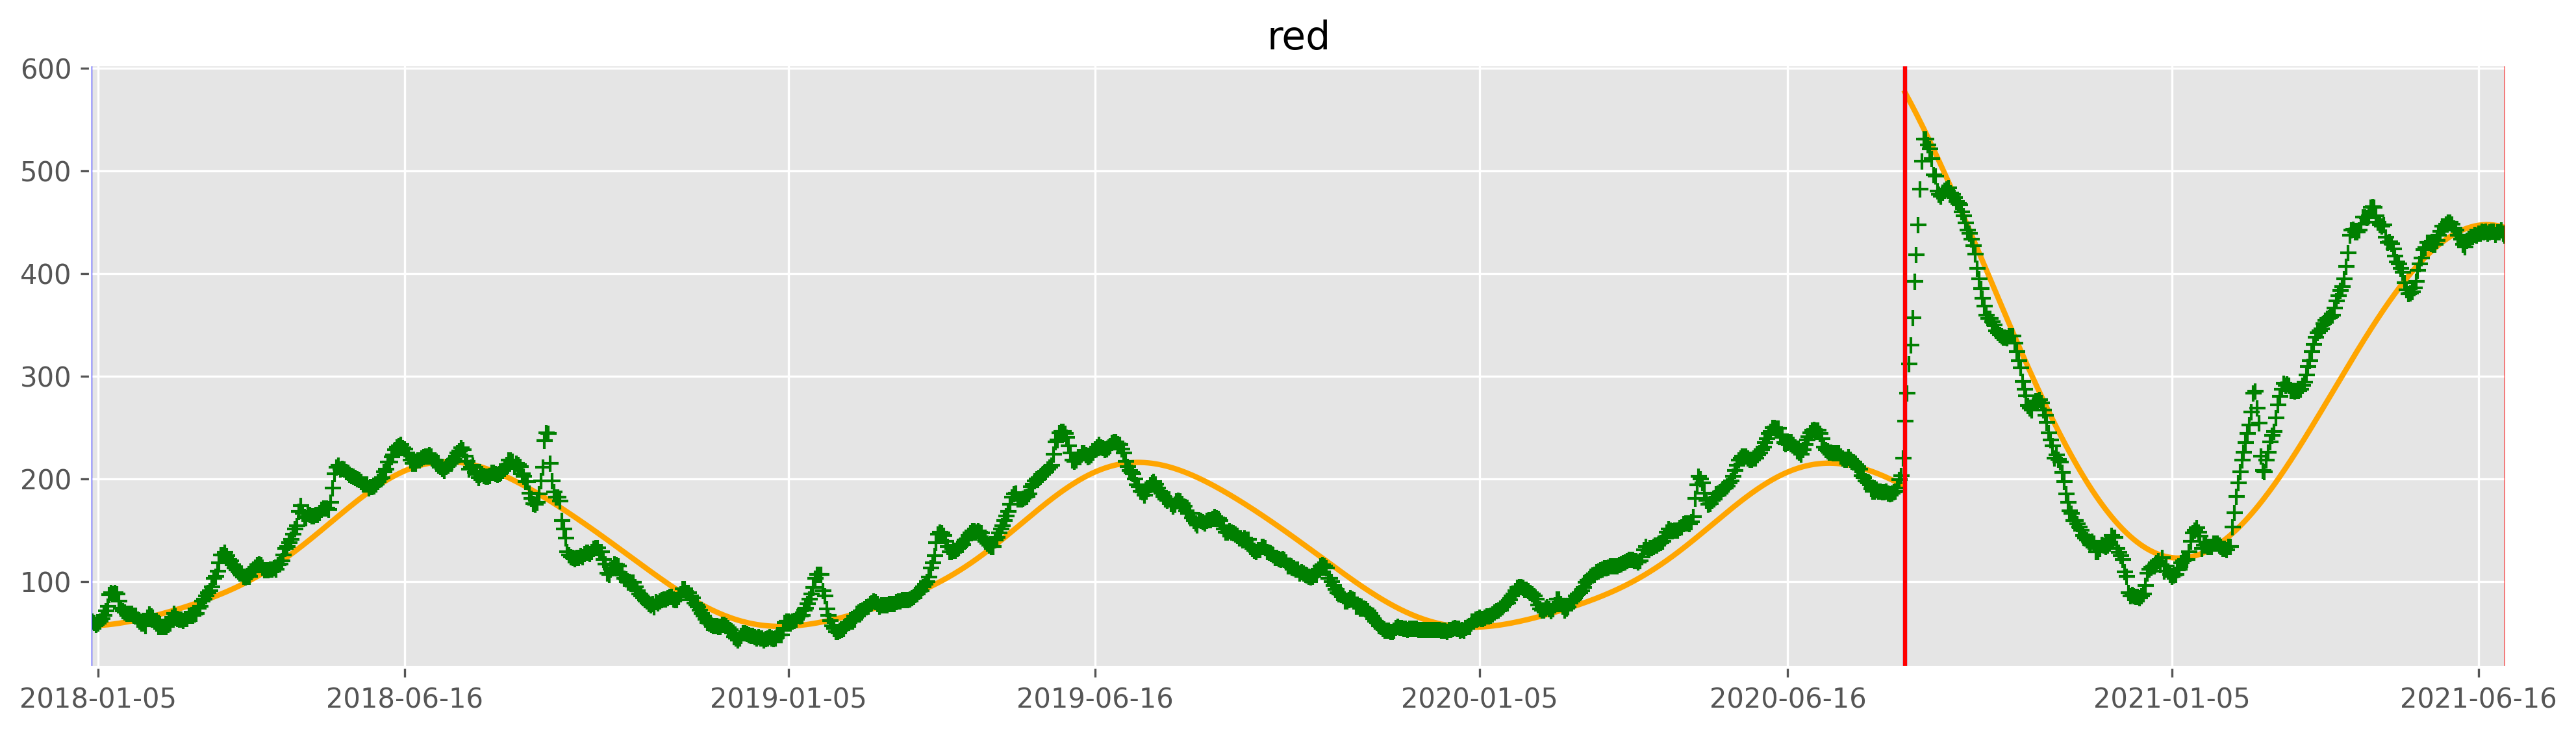

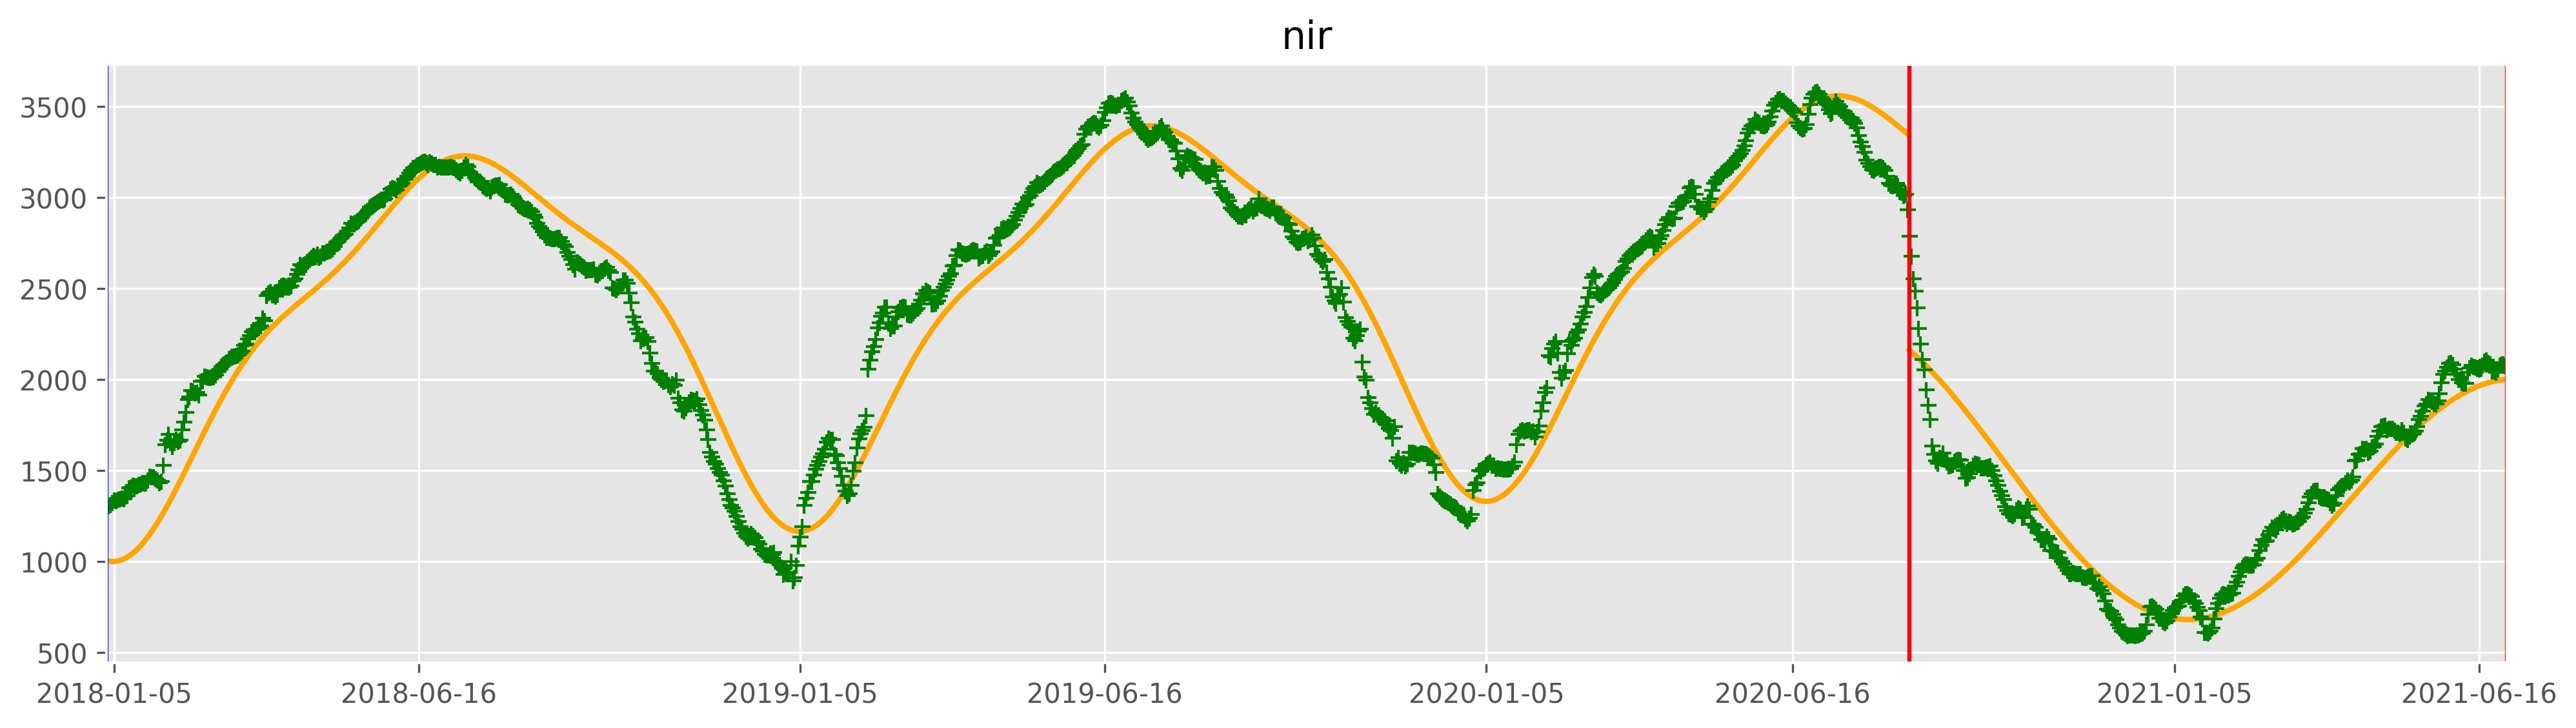

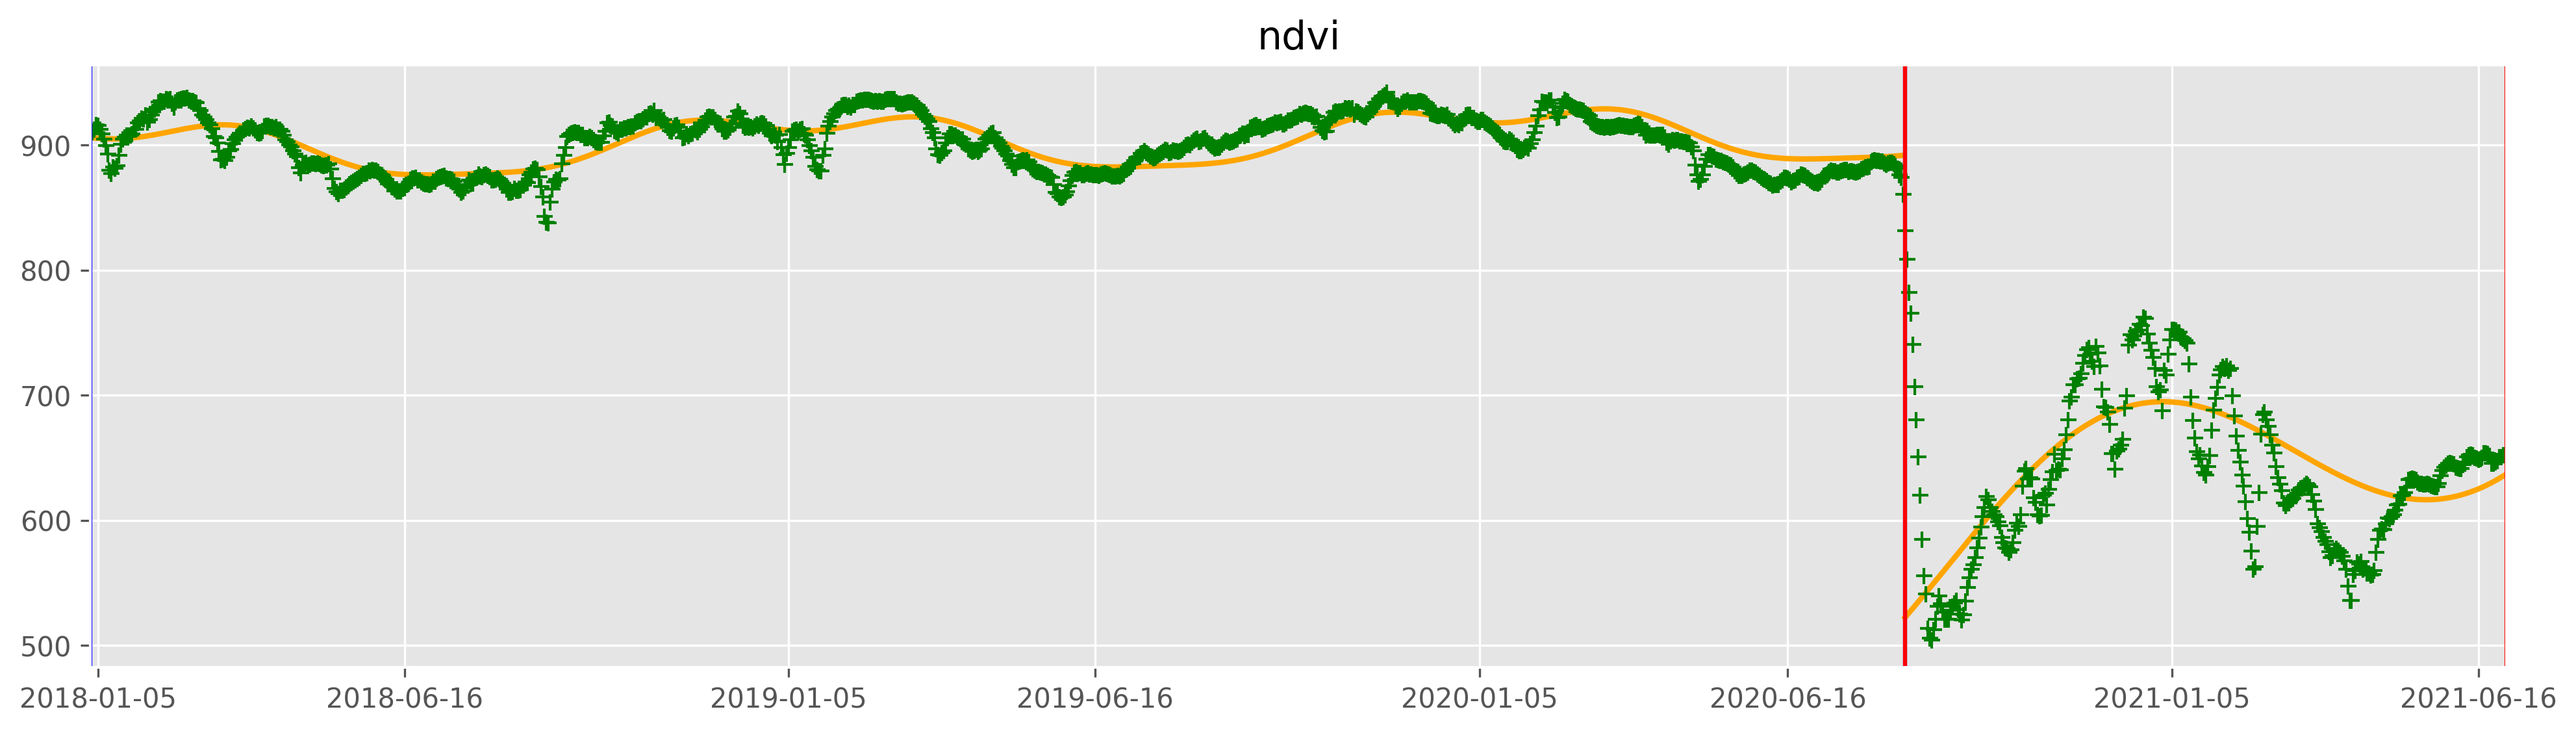

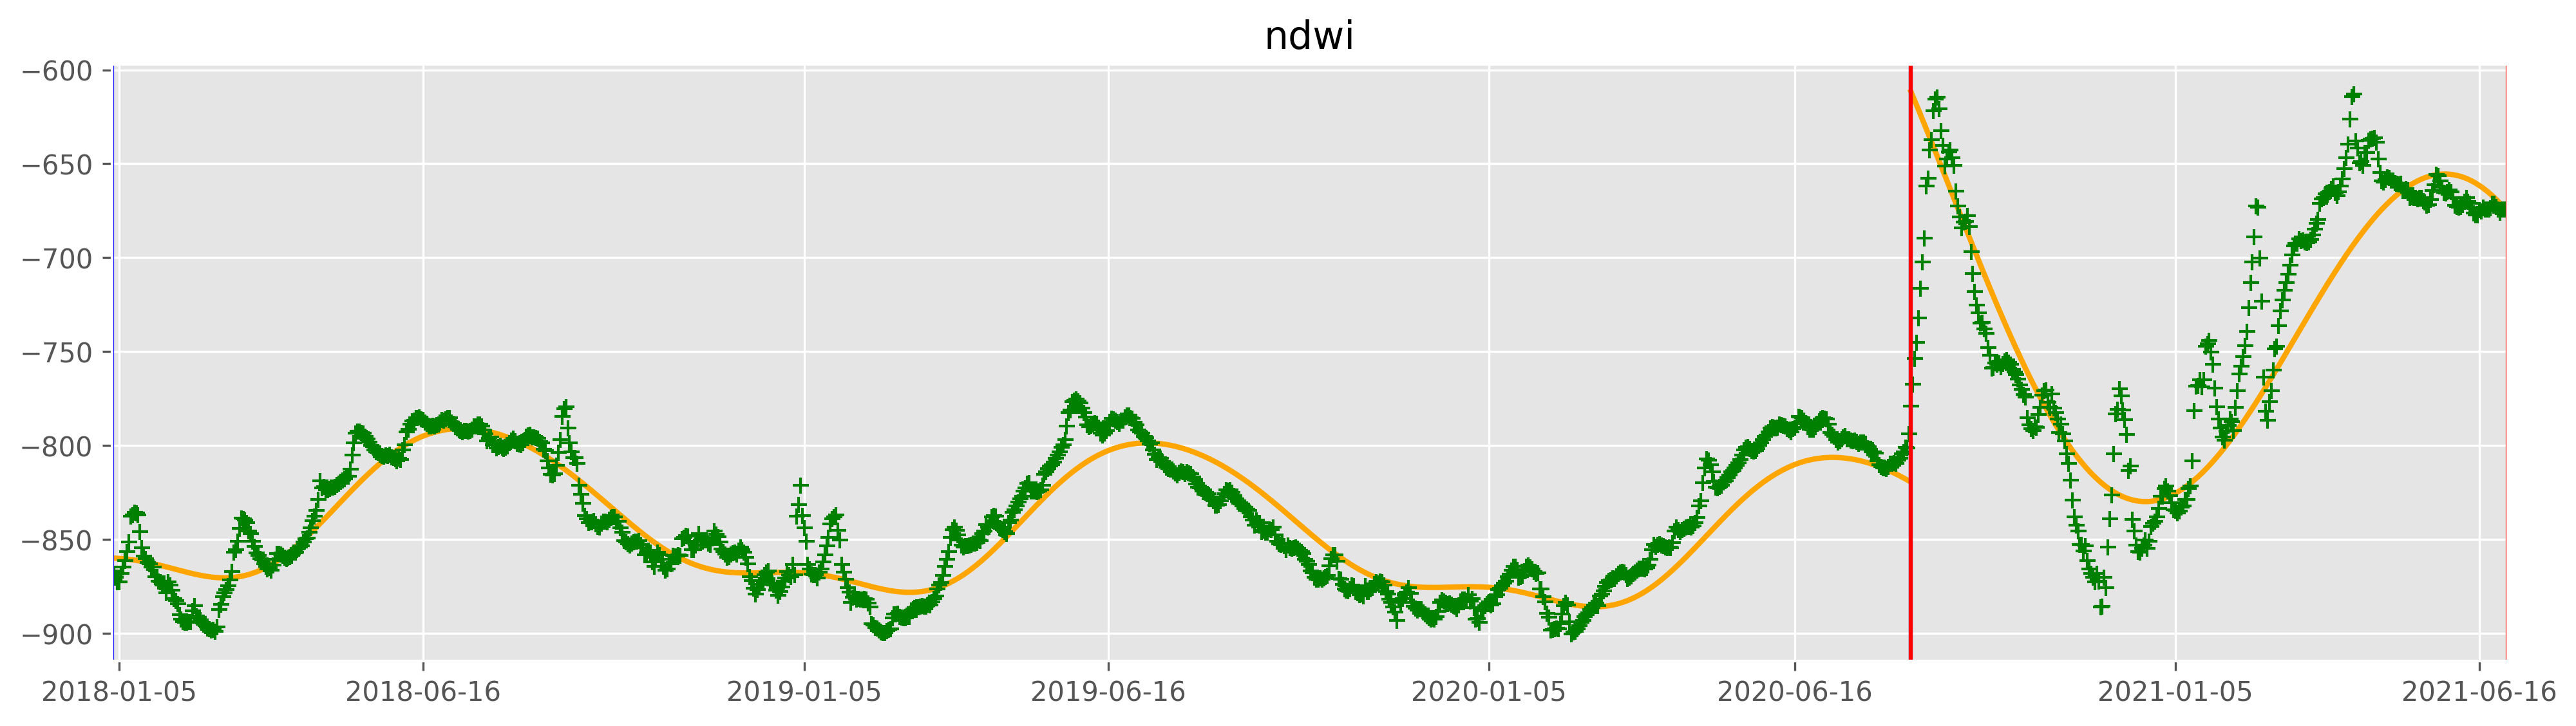

In [6]:
#Plot Results
def plot(band,bands,results,dates):
    predicted_values = []
    prediction_dates = []
    break_dates = []
    start_dates = []
    mask = np.array(results['processing_mask'], dtype=bool)
    new_dates=[]
    dates2=[]
    for k in dates:
        if (date.fromordinal(int(k)).day==16 and date.fromordinal(int(k)).month)==6 or (date.fromordinal(int(k)).day==5 and date.fromordinal(int(k)).month==1) :
            dates2.append(k)
            new_dates.append(str(date.fromordinal(int(k))))

    for num, result in enumerate(results['change_models']):
        days = np.arange(result['start_day'], result['end_day'] + 1)
        prediction_dates.append(days)
        break_dates.append(result['break_day'])
        start_dates.append(result['start_day'])
        
        intercept = result[band]['intercept']
        coef = result[band]['coefficients']
        
        predicted_values.append(intercept + coef[0] * days +
                                coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
                                coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
                                coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))
        
                    
              
    plt.style.use('ggplot')
    fg = plt.figure(figsize=(16,9), dpi=300)
    #Removed y-axis value, but can standardize later
    if band=='ndvi':
        a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)) )   
    elif band=='nir':
        a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)))
    else:
        a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)))


    for _preddate, _predvalue in zip(prediction_dates, predicted_values):
        a1.plot(_preddate, _predvalue, 'orange', linewidth=1)


    #Predicted curves
    for _preddate, _predvalue in zip(prediction_dates, predicted_values):
        a1.plot(_preddate, _predvalue, 'orange', linewidth=2)

    a1.plot(dates[mask], bands[mask], 'g+') # Observed values
    a1.plot(dates[~mask], bands[~mask], 'k+') # Observed values masked out
    for s in start_dates: a1.axvline(s, color='b')
    for b in break_dates: a1.axvline(b, color='r')
    plt.title(band)
    plt.xticks(ticks=dates2,labels=new_dates)
    return a1

    
bands = ["blue","green","red","nir","ndvi",'ndwi']
for k in range(len(bands)):
    plot(bands[k],data[k+1],results,dates)


print(pixel_x,pixel_y)
